In [1]:
#manipulação de dados e caminhos de arquivo
import pandas as pd
import numpy as np
import os
#visualização de imagens e gráficos
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
#amostras aleatórias
import random

#config gráficos
sns.set_theme(style="whitegrid")
%matplotlib inline

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# O 'r' antes da string é importante no Windows para tratar as barras invertidas corretamente
BASE_PATH = r'C:\Users\luhal\TCC\data\raw\RAF-DB'

TRAIN_PATH = os.path.join(BASE_PATH, 'DATASET', 'train')
TEST_PATH = os.path.join(BASE_PATH, 'DATASET', 'test')

print(f"Caminho de Treino: {TRAIN_PATH}")
print(f"Caminho de Teste: {TEST_PATH}")

Caminho de Treino: C:\Users\luhal\TCC\data\raw\RAF-DB\DATASET\train
Caminho de Teste: C:\Users\luhal\TCC\data\raw\RAF-DB\DATASET\test


In [3]:
print("Lendo dados a partir da estrutura de pastas...")

# Lista para guardar as informações
data_list = []
paths = {'train': TRAIN_PATH, 'test': TEST_PATH}

# Percorrer as pastas de treino e teste
for split, path in paths.items():
    
    # Listar as pastas de emoção (ex: '1', '2', '3'...)
    for emotion_id_str in os.listdir(path):
        emotion_path = os.path.join(path, emotion_id_str)
        
        # Verificar se é realmente um diretório
        if os.path.isdir(emotion_path):
            emotion_id = int(emotion_id_str)
            
            # Listar todas as imagens dentro da pasta da emoção
            for image_name in os.listdir(emotion_path):
                # Adicionar as informações à nossa lista
                data_list.append({
                    'image_name': image_name,
                    'emotion_id': emotion_id,
                    'split': split
                })

# Criar o DataFrame do pandas a partir da lista
df_raf = pd.DataFrame(data_list)

# Mapear os IDs numéricos para nomes de emoções
emotion_mapping_raf = {
    1: 'Surpresa',
    2: 'Medo',
    3: 'Nojo',
    4: 'Felicidade',
    5: 'Tristeza',
    6: 'Raiva',
    7: 'Neutro'
}
df_raf['emotion_name'] = df_raf['emotion_id'].map(emotion_mapping_raf)

print("\nDataFrame criado com sucesso!")
print("Amostra dos dados:")
df_raf.head()

Lendo dados a partir da estrutura de pastas...

DataFrame criado com sucesso!
Amostra dos dados:


,image_name,emotion_id,split,emotion_name
0,train_00006_aligned.jpg,1,train,Surpresa
1,train_00010_aligned.jpg,1,train,Surpresa
2,train_00012_aligned.jpg,1,train,Surpresa
3,train_00013_aligned.jpg,1,train,Surpresa
4,train_00032_aligned.jpg,1,train,Surpresa


Analisando a distribuição do conjunto de teste...

Distribuição das emoções na RAF-DB (Teste):
emotion_name
Felicidade    1185
Neutro         680
Tristeza       478
Surpresa       329
Raiva          162
Nojo           160
Medo            74
Name: count, dtype: int64


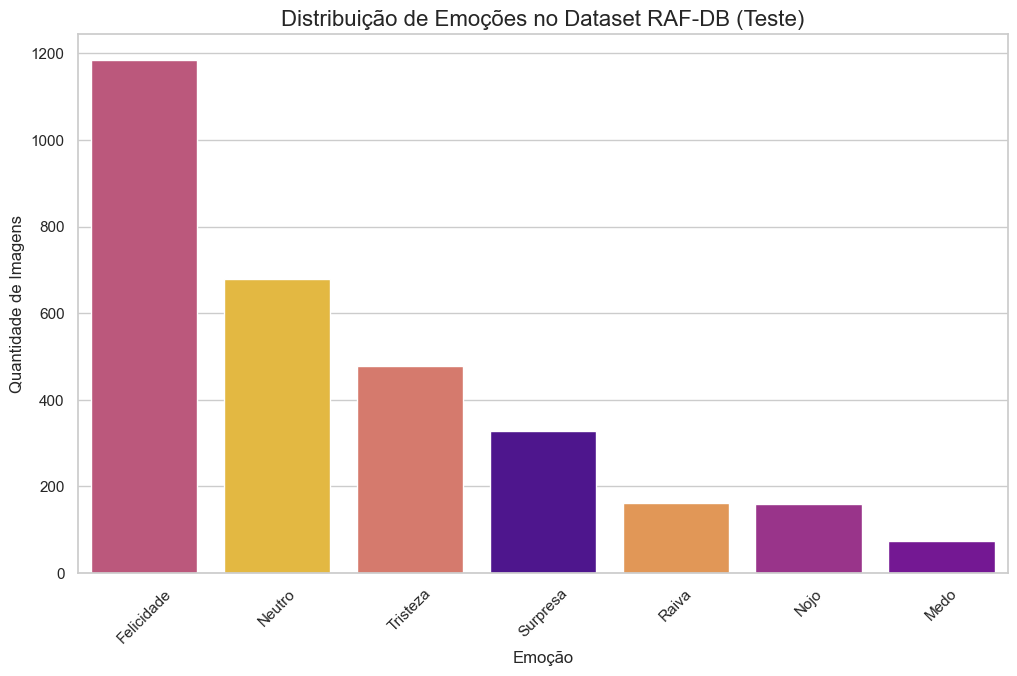

In [4]:
# --- Célula para Análise Quantitativa do Conjunto de Teste ---

# Verificar se o DataFrame df_raf existe antes de continuar
if 'df_raf' in locals():
    print("Analisando a distribuição do conjunto de teste...")
    
    # 1. Filtrar o DataFrame para conter apenas os dados de teste
    test_df = df_raf[df_raf['split'] == 'test']
    
    # 2. Contar as imagens por emoção no conjunto de teste
    test_counts = test_df['emotion_name'].value_counts()
    
    print("\nDistribuição das emoções na RAF-DB (Teste):")
    print(test_counts)
    
    # 3. Criar um gráfico de barras para visualizar essa distribuição
    plt.figure(figsize=(12, 7))
    sns.countplot(x='emotion_name',
                  data=test_df,
                  order=test_counts.index,
                  palette='plasma', # Usando uma paleta de cores diferente para distinguir
                  hue='emotion_name',
                  legend=False)
    
    plt.title('Distribuição de Emoções no Dataset RAF-DB (Teste)', fontsize=16)
    plt.xlabel('Emoção', fontsize=12)
    plt.ylabel('Quantidade de Imagens', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

else:
    print("ERRO: O DataFrame 'df_raf' não foi encontrado. Execute as células anteriores primeiro.")

In [5]:
# --- Célula para Resumo Quantitativo do Dataset ---

# Verificar se o DataFrame df_raf existe antes de continuar
if 'df_raf' in locals():
    # 1. Calcular o total de imagens
    total_images = len(df_raf)
    
    # 2. Contar as imagens em cada divisão (treino e teste)
    # O método .value_counts() é perfeito para isso
    split_counts = df_raf['split'].value_counts()
    
    train_images = split_counts.get('train', 0) # .get() para evitar erro se não houver 'train'
    test_images = split_counts.get('test', 0)
    
    # 3. Exibir os resultados de forma clara
    print("--- Resumo Quantitativo do Dataset RAF-DB ---")
    print(f"Total de Imagens no Dataset: {total_images}")
    print("-" * 45)
    print(f"Imagens de Treino: {train_images}")
    print(f"Imagens de Teste:  {test_images}")
    print("-" * 45)

else:
    print("ERRO: O DataFrame 'df_raf' não foi encontrado. Execute a célula anterior primeiro.")

--- Resumo Quantitativo do Dataset RAF-DB ---
Total de Imagens no Dataset: 15339
---------------------------------------------
Imagens de Treino: 12271
Imagens de Teste:  3068
---------------------------------------------


Iniciando a análise de dimensões de todas as imagens da RAF-DB...


Analisando imagens: 100%|████████████████████████████████████████████████████████| 15339/15339 [03:09<00:00, 80.94it/s]


--- Análise de Dimensões Concluída ---
As 10 dimensões de imagem mais comuns são:
dimensions
100x100    15339
Name: count, dtype: int64


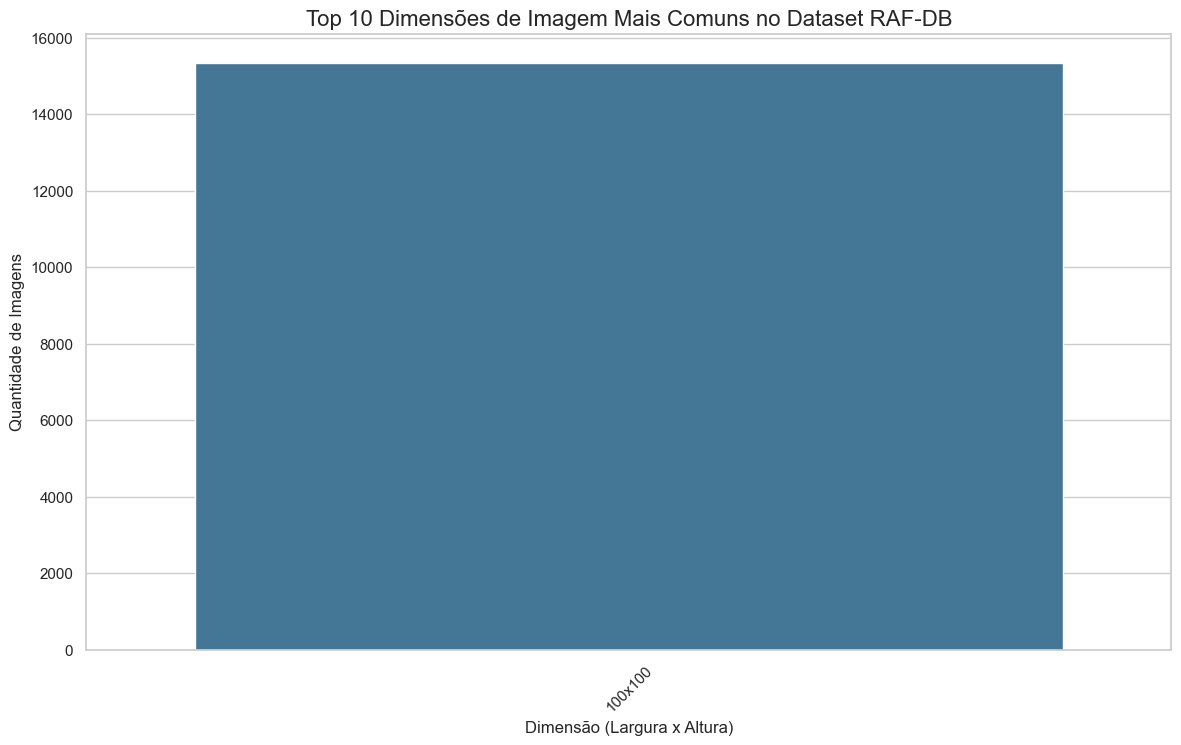

In [6]:
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

print("Iniciando a análise de dimensões de todas as imagens da RAF-DB...")

# Caminho para a pasta que contém as pastas 'train' e 'test'
# Verifique se este é o caminho correto para as imagens alinhadas/originais
path_raf_base_images = r'C:\Users\luhal\TCC\data\raw\RAF-DB\DATASET' 

# Lista para armazenar as dimensões (largura, altura) de cada imagem
image_dimensions = []

# Usar os.walk para percorrer todas as subpastas e ficheiros
# tqdm vai nos dar uma barra de progresso geral
# O total é uma aproximação para a barra de progresso (12271 treino + 3068 teste)
total_files_approx = 15339
with tqdm(total=total_files_approx, desc="Analisando imagens") as pbar:
    for root, dirs, files in os.walk(path_raf_base_images):
        for filename in files:
            # Verificar se é um ficheiro de imagem
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, filename)
                try:
                    # Ler a imagem e obter as suas dimensões
                    image = cv2.imread(image_path)
                    if image is not None:
                        h, w, _ = image.shape
                        image_dimensions.append(f'{w}x{h}') # Guardar como string 'larguraxaltura'
                except Exception as e:
                    print(f"Erro ao ler a imagem {image_path}: {e}")
                pbar.update(1)

# Converter a lista de dimensões para um DataFrame do pandas para facilitar a contagem
df_dims = pd.DataFrame(image_dimensions, columns=['dimensions'])

# Contar a frequência de cada dimensão
dimension_counts = df_dims['dimensions'].value_counts()

print("\n--- Análise de Dimensões Concluída ---")
print("As 10 dimensões de imagem mais comuns são:")
print(dimension_counts.head(10))

# Criar um gráfico de barras com as 10 dimensões mais comuns
plt.figure(figsize=(14, 8))
sns.barplot(x=dimension_counts.head(10).index, y=dimension_counts.head(10).values, palette='mako', hue=dimension_counts.head(10).index, legend=False)
plt.title('Top 10 Dimensões de Imagem Mais Comuns no Dataset RAF-DB', fontsize=16)
plt.xlabel('Dimensão (Largura x Altura)', fontsize=12)
plt.ylabel('Quantidade de Imagens', fontsize=12)
plt.xticks(rotation=45)
plt.show()

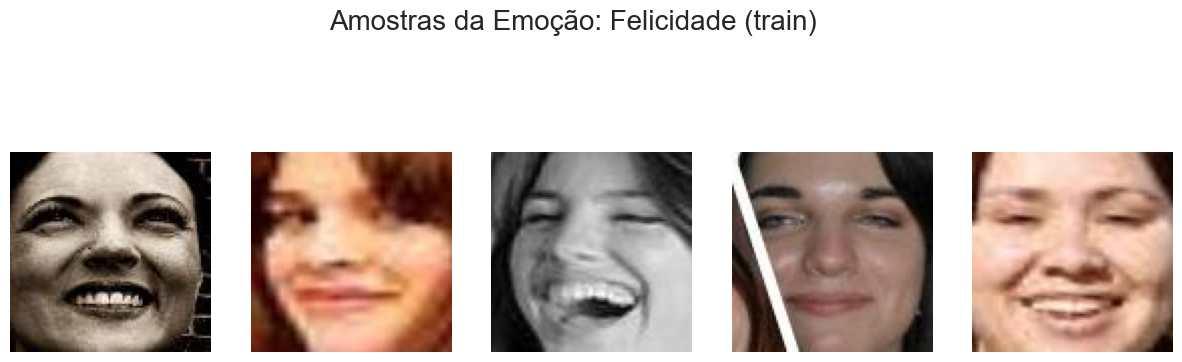

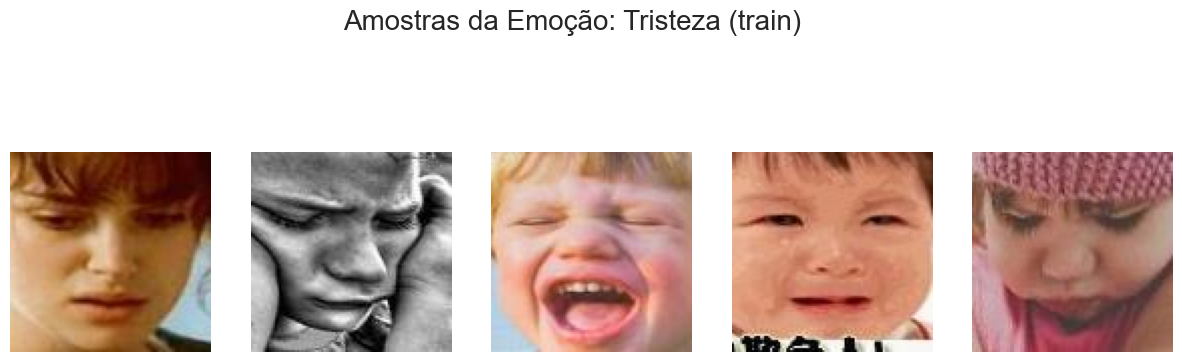

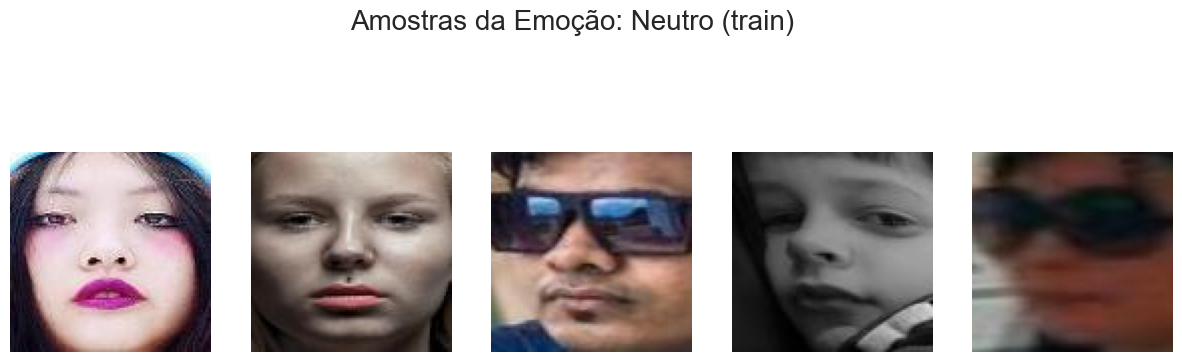

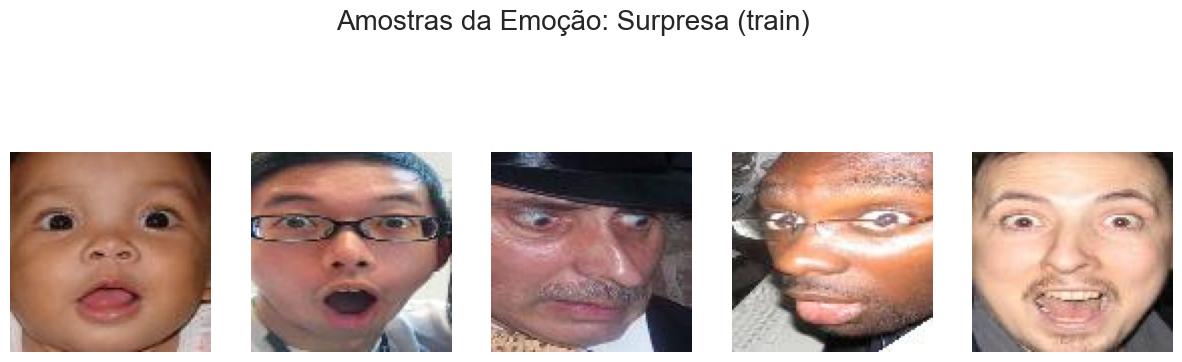

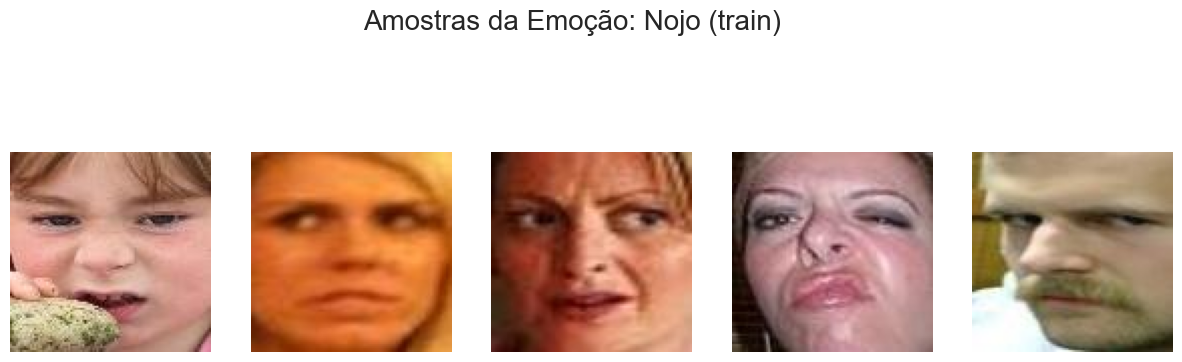

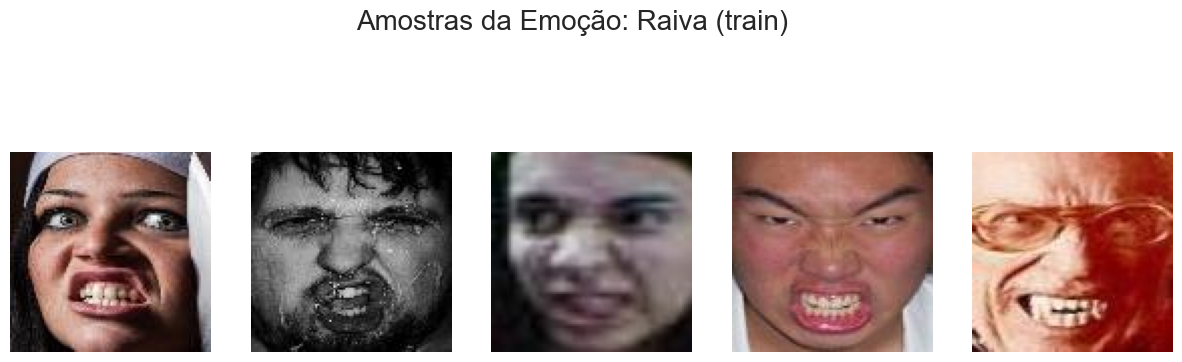

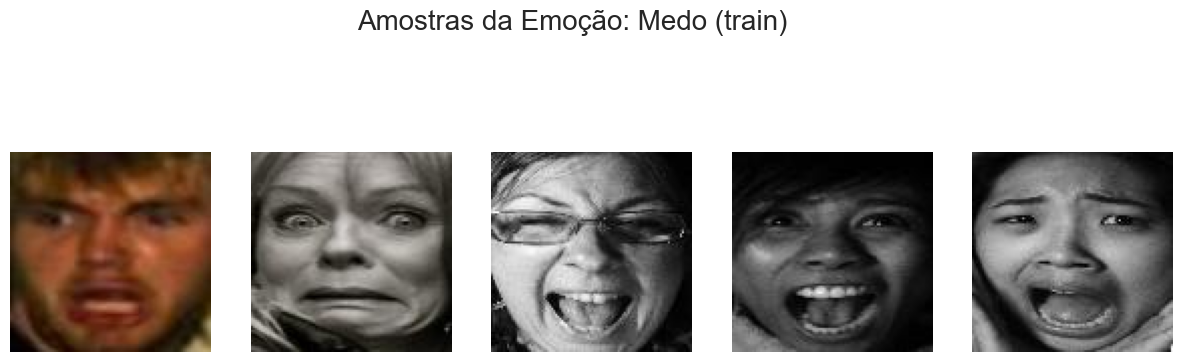

In [7]:
def show_sample_images(df, emotion_name, n_samples=5, split='train'):
    """Função para exibir imagens de uma emoção específica."""
    
    # Baseado no split (treino ou teste), define a pasta base
    base_path = TRAIN_PATH if split == 'train' else TEST_PATH
    
    # Filtra o dataframe para a emoção e o split desejado
    sample_df = df[(df['emotion_name'] == emotion_name) & (df['split'] == split)].sample(n_samples)
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Amostras da Emoção: {emotion_name} ({split})', fontsize=20)
    
    for i, row in enumerate(sample_df.itertuples(), 1):
        # Constrói o caminho completo da imagem
        # O caminho é: base_path -> pasta_da_emocao -> nome_da_imagem
        image_path = os.path.join(base_path, str(row.emotion_id), row.image_name)
        
        # Lê a imagem com OpenCV (em formato BGR)
        image = cv2.imread(image_path)
        
        # Converte de BGR para RGB para exibir corretamente com Matplotlib
        if image is not None:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Exibe a imagem
            plt.subplot(1, n_samples, i)
            plt.imshow(image_rgb)
            plt.axis('off')
        else:
            print(f"Não foi possível ler a imagem: {image_path}")
        
    plt.show()

show_sample_images(df_raf, 'Felicidade')
show_sample_images(df_raf, 'Tristeza')
show_sample_images(df_raf, 'Neutro')
show_sample_images(df_raf, 'Surpresa')
show_sample_images(df_raf, 'Nojo')
show_sample_images(df_raf, 'Raiva')
show_sample_images(df_raf, 'Medo')